In [1]:
# %load_ext autoreload
# %autoreload 2

### Authors:
- [Karan Bhagat](mailto:kb.in.triangulum@gmail.com) - Developer
- [Christine Task](mailto:christine.task@knexusresearch.com) - Project technical lead
- [Dhruv Kapur](mailto:dhruvka@umich.edu) - Contributor

## NIST Collaborative Research Cycle (CRC)
### Example Notebook 1: Analysing k-marginal score of deidentified datasets.
K-marginal is an overall edit distance metric that gives us a similarity score between the target data and deidentified data. Because it uses marginals to compare distributions it can operate equally well on very sparse distributions (where the L1 norm isn't applicable); it was developed by Dr. Sergey Pogodin for the NIST Synthetic Data Challenges.  A score closer to 1000 means the two distributions are very similar and the deidentified data should have a high utility for analysis.   More information is available in the report.html files in the data-and-metrics-bundle.   

Here we demonstrate using a notebook to collect k-marginal scores from the metrics results for all of the deidentified data submissions in the data and metrics archive.   We try plotting these scores as bar plots based on different algorithm properties.  Notice how wide the error bars are on the bar plots; none of these properties by itself explains the variance we see in the archive.
#### List of topics covered in this notebook:
0. [Setup notebook.](#nb1-section-0)
1. [Load deid datasets index file (index.csv).](#nb1-section-1)  
<!--    1.1 [List properties (columns) of each deid. dataset (each row) in the index dataframe (created from index.csv).](#section-1.1)  -->
2. [Get k-marginal score for every deid dataset.](#nb1-section-2)
3. [Plot average k-marginal score by deidentification algorithm type.](#nb1-section-3)  
<!--    3.1 [Calculate average k-marginal score of each deidentification algorithm type.](#section-3.1)  
   3.2 [Plot average k-marginal score of each deidentification algorithm type.](#section-3.2)   -->
4. [Plot average k-marginal score by category of privacy approach.](#nb1-section-4)  
<!--    4.1 [Calculate average k-marginal score of each privacy category](#section-4.1)   
   4.2 [Plot average k-marginal score of each privacy category](#section-4.2)    -->

<a id="nb1-section-0"></a>
## Setup notebook.

### Import required libraries

In [2]:
# import required libraries
from pathlib import Path  # for creating paths for the filesystem operations
import os  # for filesystem operations
import pandas as pd  # for tabular data operations
import numpy as np  # for tabular data operations
import matplotlib.pyplot as plt  # for plotting data as charts
import json

### Import local libraries present in libs package

In [3]:
# Import helper constants and functions
# libs.util has some small utility functions
# such has read_json, list_report etc.
import libs.util as u
# libs.plot module contains some helper
# funtions to create matplotlib charts
import libs.plot as plot
# libs.strs contains some constant strings
# represeting columns/feature names in index.csv file,
# report.json file, etc.
# Some examples of such constants: 
# LIBRARY_NAME, ALOGIRTHM_NAME, TARGET_DATASETetc.
from libs.strs import *
# lib.strs provides get_colors function that can be
# use to generate N random colors.
import libs.color as color

### Change Current Working Directory (CWD) to: crc_data_and_metric_bundle

In [4]:
print('CWD Before: ', Path.cwd())
# get current working directory
cwd = Path.cwd()
# get path to the directory where is notebook is located
notebook_dir = u.notebook_path()
# Name of the parent directory of this notebook is crc_data_and_metric_bundle_1.0
new_cwd = notebook_dir.parent
# Set new current working directory path which ends in crc_data_and_metric_bundle_1.0
os.chdir(new_cwd)
print('CWD After: ', Path.cwd())

CWD Before:  /Users/karan/Documents/Knexus/NIST/SDNist/crc_acceleration_bundle_1.1/crc_data_and_metric_bundle_1.1/notebooks
CWD After:  /Users/karan/Documents/Knexus/NIST/SDNist/crc_acceleration_bundle_1.1/crc_data_and_metric_bundle_1.1


<a id="nb1-section-1"></a>
## 1. Load deid datasets index file (index.csv)
index.csv file has tabular information about the deidentified (deid) datasets created using different data-deidentification libraries and algorithms. 
#### Location of index.csv: *crc_data_and_metric_bundle_1.0/index.csv*
#### Location of this notebook: *crc_data_and_metric_bundle_1.0/notebooks/intro.ipynb*

In [5]:
CWD = Path.cwd()  # get current working directory path
# Create path to the index.csv file
INDEX_FILE_PATH = Path(CWD, 'index.csv')
# read index csv into idx_df variable
# idx stands for index
idx_df = pd.read_csv(INDEX_FILE_PATH, index_col=0).reset_index(drop=True)

Index data has a total of 298 different deid. datasets and each dataset has 23 different properties.

In [6]:
# See the shape of the index dataframe.
idx_df.shape

(458, 22)

In [7]:
# See five random rows of the index dataframe
idx_df.sample(5)

,library name,algorithm name,algorithm type,target dataset,feature set name,feature space size,features list,privacy category,privacy label detail,epsilon,...,variant label detail,research papers,data path,labels path,report path,team,submission number,submission timestamp,quasi identifiers subset,deid data id
250,smartnoise-synth,pacsynth,query matching,ma2019,family-focused,58212000000,"PUMA, AGEP, SEX, MSP, HISP, RAC1P, NOC, NPF, O...",dp,The pac-synth synthesizer will suppress margin...,5.0,...,NaN,https://github.com/microsoft/synthetic-data-sh...,deid_data/smartnoise_pacsynth/ma/pacsynth_e_5_...,deid_data/smartnoise_pacsynth/ma/pacsynth_e_5_...,deid_data/smartnoise_pacsynth/ma/report_pacsyn...,CRC,NaN,9/5/2023 00:00:00,NaN,d1c505204c355d0920659bc51fd34d490ef2a63e
263,smartnoise-synth,pacsynth,query matching,national2019,industry-focused,108108000,"PUMA, SEX, MSP, HISP, RAC1P, OWN_RENT, INDP_CA...",dp,The pac-synth synthesizer will suppress margin...,10.0,...,NaN,https://github.com/microsoft/synthetic-data-sh...,deid_data/smartnoise_pacsynth/national/pac_syn...,deid_data/smartnoise_pacsynth/national/pac_syn...,deid_data/smartnoise_pacsynth/national/report_...,CRC,NaN,5/20/2023 00:00:00,NaN,b0a133c78c4b15eb14a47fc0267ab5926227648d
79,sdcmicro,kanonymity,sdc,ma2019,family-focused,58212000000,"PUMA, AGEP, SEX, MSP, HISP, RAC1P, NOC, NPF, O...",sdc,The sdcMicro package includes two functions fo...,NaN,...,"k: 12, all features as key features",https://doi.org/10.18637/jss.v067.i04,deid_data/sdcmicro_k_anonymity/ma/k_anonymity_...,deid_data/sdcmicro_k_anonymity/ma/k_anonymity_...,deid_data/sdcmicro_k_anonymity/ma/report_k_ano...,CRC,NaN,6/16/2023 00:00:00,NaN,479283081da75b33b7373fe0f7a5d69a983683f2
194,smartnoise-synth,mst,stat model,ma2019,demographic-focused,227026800,"AGEP, SEX, MSP, RAC1P, HOUSING_TYPE, OWN_RENT,...",dp,Differentially private synthetic data. From M...,1.0,...,NaN,https://doi.org/10.48550/arXiv.2108.04978,deid_data/smartnoise_mst/ma/mst_e_1_demographi...,deid_data/smartnoise_mst/ma/mst_e_1_demographi...,deid_data/smartnoise_mst/ma/report_mst_e_1_dem...,CRC,NaN,9/5/2023 00:00:00,NaN,1db2c49587abae371c12872c319ef9b9ec339ae3
102,sdcmicro,pram,sdc,national2019,demographic-focused,227026800,"AGEP, SEX, MSP, RAC1P, HOUSING_TYPE, OWN_RENT,...",sdc,The algorithm randomly changes the values of v...,NaN,...,"pd: 0.8, alpha: 0.5, pram features: quasi cat....",https://doi.org/10.3390/a12090191,deid_data/sdcmicro_pram/national/pram_default_...,deid_data/sdcmicro_pram/national/pram_default_...,deid_data/sdcmicro_pram/national/report_pram_d...,CRC,NaN,5/20/2023 00:00:00,"MSP, RAC1P, OWN_RENT, EDU",fa83c5dbd0e2692717c2f08cd28bbf91f0d13191


### 1.1 Veiw available features in the index dataframe.
List features(columns) of each deid. dataset (each row) in the index dataframe (created from index.csv). 

Some features inform about the method of data synthesis (features such as 'library', 'algorithm name', 'epsilon', 'variant label' etc.) and others about the location of resources (such as 'data path' path to deid dataset csv file, 
'report path' path to sdnist evaluation report of the deid dataset file etc.)

In [8]:
# Iterate over the columns of index dataframe
# and print each column name
for col in idx_df.columns:
    print(col)

library name
algorithm name
algorithm type
target dataset
feature set name
feature space size
features list
privacy category
privacy label detail
epsilon
delta
variant label
variant label detail
research papers
data path
labels path
report path
team
submission number
submission timestamp
quasi identifiers subset
deid data id


In [9]:
# Use index_feature_description function from the libs.util module.
# index_feature_description function takes just one argument which 
# should be one of the column name available in the index file. 
# Column names are printed in the last code cell for your reference.
u.index_feature_description(LIBRARY_NAME)


Index Column: 
-------------
library name


Description:
-----------
Software library used for this submission, or team name if a private codebase was used


<a id="nb1-section-2"></a>
## 2. Get k-marginal score for every deid dataset.

In [10]:
# Create a new zero filled column
idx_df[K_MARGINAL_SCORE] = np.zeros(idx_df.shape[0]).astype(int)

# Iterate over each row (deid dataset) in filtered index dataframe.
for i, row in idx_df.iterrows():
    # Get path of the SDNIST evaluation report directory
    # for the deid dataset in current row.
    report_dir_path = row[REPORT_PATH]  # report directory path
    # Create path to the report.json file in the report directory.
    report_json_path = Path(report_dir_path, 'report.json')
    # Read the json file at report_json_path into a 
    # python dictionary variable report_dict.
    with open(report_json_path) as f:
        report_dict = json.load(f)
    # Get the k-marginal score from the report dictionary. 
    k_marg_score = report_dict[K_MARGINAL][K_MARGINAL_SYNOPSYS][K_MARGINAL_SCORE]
    
    # Save k-marginal score of the deid dataset in current row
    idx_df.loc[i, K_MARGINAL_SCORE] = k_marg_score

# See the five random records and 
# the new column k-marginal score which we added to 
# the filtered index dataframe just now.
columns_to_show = [LIBRARY_NAME, ALGORITHM_NAME, ALGORITHM_TYPE, 
                   PRIVACY_CATEGORY, K_MARGINAL_SCORE]
idx_df[columns_to_show].sample(5)

,library name,algorithm name,algorithm type,privacy category,k_marginal_score
367,synthcity,pategan,neural net,dp,783
259,smartnoise-synth,pacsynth,query matching,dp,428
24,MostlyAI SD,MostlyAI SD,neural net,non_dp,926
236,smartnoise-synth,mst,stat model,dp,902
357,synthcity,bayesian_network,stat model,non_dp,721


<a id="nb1-section-3"></a>
## 3. Plot average k-marginal score by deidentification algorithm type.

<a id="nb1-section-3.1"></a>
### 3.1 Calculate average k-marginal score of each deidentification algorithm type.

In [11]:
u.index_feature_description(ALGORITHM_TYPE)


Index Column: 
-------------
algorithm type


Description:
-----------
A label indicating the general category of approach as specified below

sdc = 'Statistical Disclosure Control anonymization techniques-- Does direct perturbation, anonymization, redaction or generalization on individual records of target data'

query matching = 'Query Matching based synthetic data techniques-- Initializes a default synthetic data distribution and iteratively updates it to mimic query results on target data, using optimization or constraint satisfaction approaches'

neural net = 'Neural Network based synthetic data techniques-- Includes both GAN and Transformer Networks / Autoencoders'

stat model = 'Statistical Model based synthetic data techniques-- Uses some approach, other than a neural network, to construct a model of the feature relationships in the target data and uses this model to generate new records.'

histogram = 'Histogram based generation techniques-- Transforms the target data into a 

In [12]:
AVG_K_MARGINAL_SCORE = 'avg_k_marginal_score'
STD_K_MARGINAL_SCORE = 'std_k_marginal_score'
# Group column algorithm type, and take average of rows in each algorithm type.
avg_kmarg_idx_df = idx_df[[ALGORITHM_TYPE, K_MARGINAL_SCORE]].groupby(ALGORITHM_TYPE).mean()

# Compute standard deviation of k marginal score in each algorithm type to show error bars
# in the k marginal score bar plots
std_kmarg_idx_df = idx_df[[ALGORITHM_TYPE, K_MARGINAL_SCORE]].groupby(ALGORITHM_TYPE).std()

# save standard deviation to the avg_kmarg_idx_df
avg_kmarg_idx_df[STD_K_MARGINAL_SCORE] = std_kmarg_idx_df

# algorithm type is now index of the new avg_kmarg_idx_df dataframe
# but we move it back into the column algorithm type by
# resetting index
avg_kmarg_idx_df = avg_kmarg_idx_df.reset_index(level=[ALGORITHM_TYPE])

# Also rename column k_marginal_score to avg_k_marginal_score
avg_kmarg_idx_df = avg_kmarg_idx_df.rename(columns={K_MARGINAL_SCORE: AVG_K_MARGINAL_SCORE})
# Show average k-marginal score of each algorithm type
avg_kmarg_idx_df

,algorithm type,avg_k_marginal_score,std_k_marginal_score
0,geometric,922.333333,3.535534
1,histogram,781.750000,235.647319
2,neural net,672.242604,176.762032
3,query matching,767.333333,184.556377
4,sdc,802.982143,195.450574
5,stat model,862.075342,104.817548


<a id="nb1-section-3.2"></a>
### 3.2 Plot average k-marginal score of each deidentification algorithm type

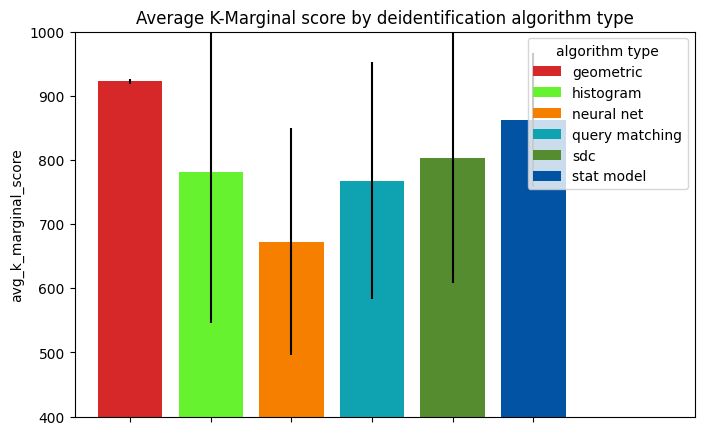

In [13]:
# Get different colors using libs.color module
colors = color.get_colors(avg_kmarg_idx_df.shape[0])

# Get unique algorithm types available in avg kmarg index data
unique_algo_types = avg_kmarg_idx_df[ALGORITHM_TYPE].unique().tolist()

# Create color map to denote different color to each
# algorithm type
color_map = {algo_type: colors[i] 
             for i, algo_type in enumerate(unique_algo_types)}

# Use bar function in libs.plot module to plot a bar chart
# x_axis_size is given 8 to just move bars a little bit so 
# that bars don't overlap with the legend
plot.bar(data=avg_kmarg_idx_df, height_column=AVG_K_MARGINAL_SCORE, 
         color_by=ALGORITHM_TYPE, color_map=color_map, 
         y_err_column=STD_K_MARGINAL_SCORE, 
         x_axis_size=8,
         y_axis_range=(400, 1000),
         title='Average K-Marginal score by deidentification algorithm type')

<a id="nb1-section-4"></a>
## 4. Plot average k-marginal score by category of privacy approach.

<a id="nb1-section-4.1"></a>
### 4.1 Calculate average k-marginal score of each privacy category

In [14]:
u.index_feature_description(PRIVACY_CATEGORY)


Index Column: 
-------------
privacy category


Description:
-----------
A code indicating the general category of privacy protection as specified below

sdc = 'Statistical Disclosure Control'

dp = 'Differential Privacy'

non_dp = 'Synthetic Data (Non-differentially Private)'


In [15]:
# Group column privacy category, and take average of rows in each privacy category.
avg_kmarg_idx_df = idx_df[[PRIVACY_CATEGORY, K_MARGINAL_SCORE]].groupby(PRIVACY_CATEGORY).mean()

# Compute standard deviation of k marginal score in each privacy category to show error bars
# in the k marginal score bar plots
std_kmarg_idx_df = idx_df[[PRIVACY_CATEGORY, K_MARGINAL_SCORE]].groupby(PRIVACY_CATEGORY).std()

# save standard deviation to the avg_kmarg_idx_df
avg_kmarg_idx_df[STD_K_MARGINAL_SCORE] = std_kmarg_idx_df

# privacy category is now index of the new avg_kmarg_idx_df dataframe
# but we move it back into the column privacy category by
# resetting index
avg_kmarg_idx_df = avg_kmarg_idx_df.reset_index(level=[PRIVACY_CATEGORY])

# Also rename column k_marginal_score to avg_k_marginal_score
avg_kmarg_idx_df = avg_kmarg_idx_df.rename(columns={K_MARGINAL_SCORE: AVG_K_MARGINAL_SCORE})
# Show average k-marginal score of each algorithm type
avg_kmarg_idx_df

,privacy category,avg_k_marginal_score,std_k_marginal_score
0,dp,772.042308,179.971239
1,non_dp,753.992958,174.723794
2,sdc,802.982143,195.450574


<a id="nb1-section-4.2"></a>
### 4.2 Plot average k-marginal score of each privacy category

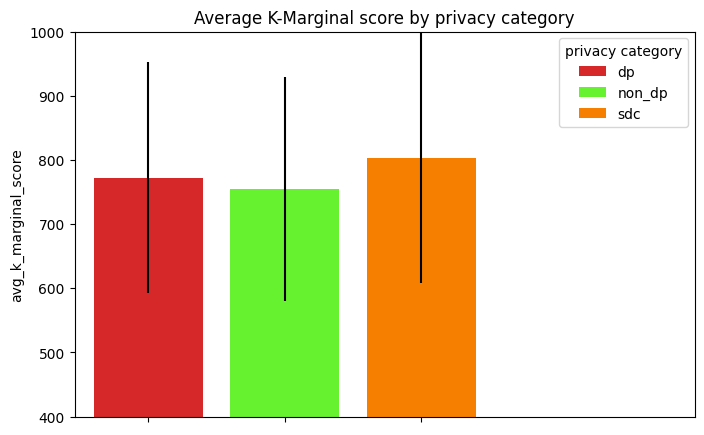

In [16]:
# Get different colors using libs.color module
colors = color.get_colors(avg_kmarg_idx_df.shape[0])

# Get unique privacy categories available in avg kmarg index data
unique_algo_types = avg_kmarg_idx_df[PRIVACY_CATEGORY].unique().tolist()

# Create color map to denote different color to each
# privacy category
color_map = {algo_type: colors[i] 
             for i, algo_type in enumerate(unique_algo_types)}

# Use bar function in libs.plot module to plot a bar chart
# x_axis_size is given 5 to move the bars a bit to the left so 
# that bars don't overlap with the legend.
plot.bar(data=avg_kmarg_idx_df, height_column=AVG_K_MARGINAL_SCORE, 
         color_by=PRIVACY_CATEGORY, color_map=color_map, 
         y_err_column=STD_K_MARGINAL_SCORE, x_axis_size=5,
         y_axis_range=(400, 1000),
         title='Average K-Marginal score by privacy category')